<h1 style="color:darkred;">I - Loading libraries</h1>

In [11]:
# Data handling
import xarray as xr
import netCDF4
import numpy as np
import regionmask

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Cartopy for mapping
import cartopy.crs as ccrs
import contextily as ctx

# Geospatial data handling
import geopandas as gpd

# calendar provide useful functions to work with dates and times
import calendar


<h1 style="color:darkred;">II - Study Area</h1>

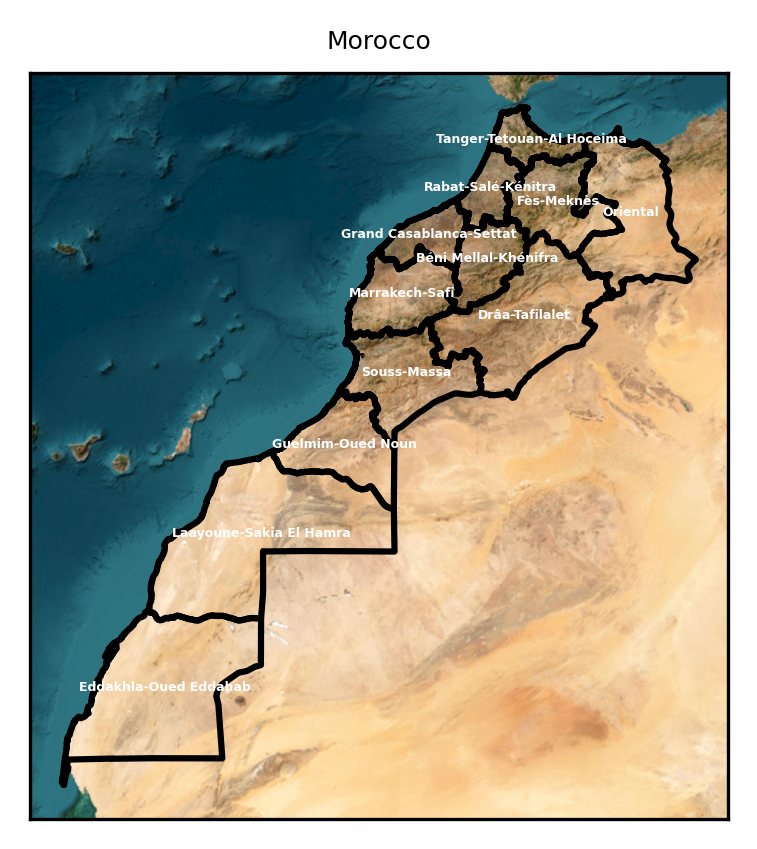

In [2]:
# Load the regions and country boundaries
morocco_boundary = gpd.read_file("/content/drive/MyDrive/Shapefiles/DA_12R_Shapefiles/DA_REGIONS_12R.shp")

# Plot the country boundary
fig, ax = plt.subplots(figsize=(3,4), dpi=300)
morocco_boundary.boundary.plot(ax=ax, color='black')

# Add basemap from Esri WorldImagery
ctx.add_basemap(ax, zoom=6, crs=morocco_boundary.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution='')

# Plot region names at the centroid of each region
for idx, row in morocco_boundary.iterrows():
    # Get the centroid for each region
    centroid = row.geometry.centroid
    # Plot the name of the region
    ax.text(centroid.x, centroid.y, row['Nom_Region'], fontsize=3, ha='center', color='white', fontweight='bold')

ax.set_xticks([])
ax.set_yticks([])

# Set the title for the plot
ax.set_title('Morocco', fontsize=6)

# Show the plot
plt.show()


<h1 style="color:darkred;">III - Importing datasets</h1>

The subsequent function is defined for the purpose of clipping our datasets within the designated study area, ensuring relevance for subsequent plots.

In [3]:
# a function to mask the dataset on the study area
def clip_dataset(ds,lon_min=-18, lon_max=0,lat_min=20, lat_max=38):
    lon_range = slice(lon_min, lon_max)
    lat_range = slice(lat_min, lat_max)

    var_lon = None
    var_lat = None
    variable_names = list(ds.variables)

    for var_name in variable_names:
        if var_name.startswith('lon'):
            var_lon = var_name
        elif var_name.startswith('lat'):
            var_lat = var_name


    mask = (ds[var_lon] >= lon_range.start) & (ds[var_lon] <= lon_range.stop) & \
           (ds[var_lat] >= lat_range.start) & (ds[var_lat] <= lat_range.stop)
    # Apply the mask to the dataset
    ds_masked=ds.where(mask, drop=True)
    return ds_masked

For the ERA5 dataset, precipitation values are expressed in meters, requiring conversion to mm, the standard unit for precipitations (1m = 1000mm). Additionally, since the downloaded data are provided on an hourly basis, we will calculate cumulative daily precipitations using the .resample(time='1D') method.

In [4]:
ds_ERA5 = clip_dataset(xr.open_dataset('ERA5_hourly.nc'))
ds_ERA5['tp'] *= 1000  # Convert 'tp' from m to mm
# Resample the dataset to daily frequency
ds_ERA5= ds_ERA5.resample(time='1D').sum()
ds_ERA5

<xarray.Dataset> Size: 78MB
Dimensions:    (time: 1826, latitude: 73, longitude: 73)
Coordinates:
  * longitude  (longitude) float32 292B -18.0 -17.75 -17.5 ... -0.5 -0.25 0.0
  * latitude   (latitude) float32 292B 38.0 37.75 37.5 37.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 15kB 2019-01-01 2019-01-02 ... 2023-12-31
Data variables:
    tp         (time, latitude, longitude) float64 78MB 0.9054 ... 4.163e-14
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-17 00:41:25 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

This dataset represents gridded time-series data of total precipitation (denoted as tp) over the Moroccan domain, stored in NetCDF format.

**Dimensions:**

*   Longitude (73 points): Covers the range from -18.0° to 0.0° with a spatial resolution of 0.25°.
*   Latitude (73 points): Extends from 20.0° to 38.0° with a spatial resolution of 0.25°.
*   Time (1826 points): Spans daily data from January 1, 2019, to December 31, 2023, providing 5 years of records.

**Data Variables:**


*  tp (Total Precipitation): A 3D variable (time, latitude, longitude) containing float64 values. The data represents daily precipitation totals (in meters) across the Moroccan region.

In [5]:
tp = ds_ERA5['tp']

# Check for missing values
missing_values = tp.isnull().sum()
print(f"Number of missing values: {missing_values.values}")

# Check for negative values
negative_values = (tp < 0).sum()
print(f"Number of negative values: {negative_values.values}")

Number of missing values: 0
Number of negative values: 0


- ### <span style="color:darkred;">Spatial distribution of annual cumulative precipitation</span>

This follwing code calculates and visualizes the cumulative annual precipitation for each year from 2019 to 2023 using ERA5 data. It creates subplots for each year, showing the spatial distribution of cumulative precipitation with a discrete colormap and colorbar. The plots include statistics for minimum, maximum, and mean precipitation values for each year.

In [6]:
# Define the years
years = [2019, 2020, 2021, 2022, 2023]

# Calculate the mean precipitation for each year
mean_precipitation = {}
for year in years:
    ds_year = ds_ERA5.sel(time=str(year))
    mean_precipitation[year] = np.sum(ds_year["tp"], axis=0)

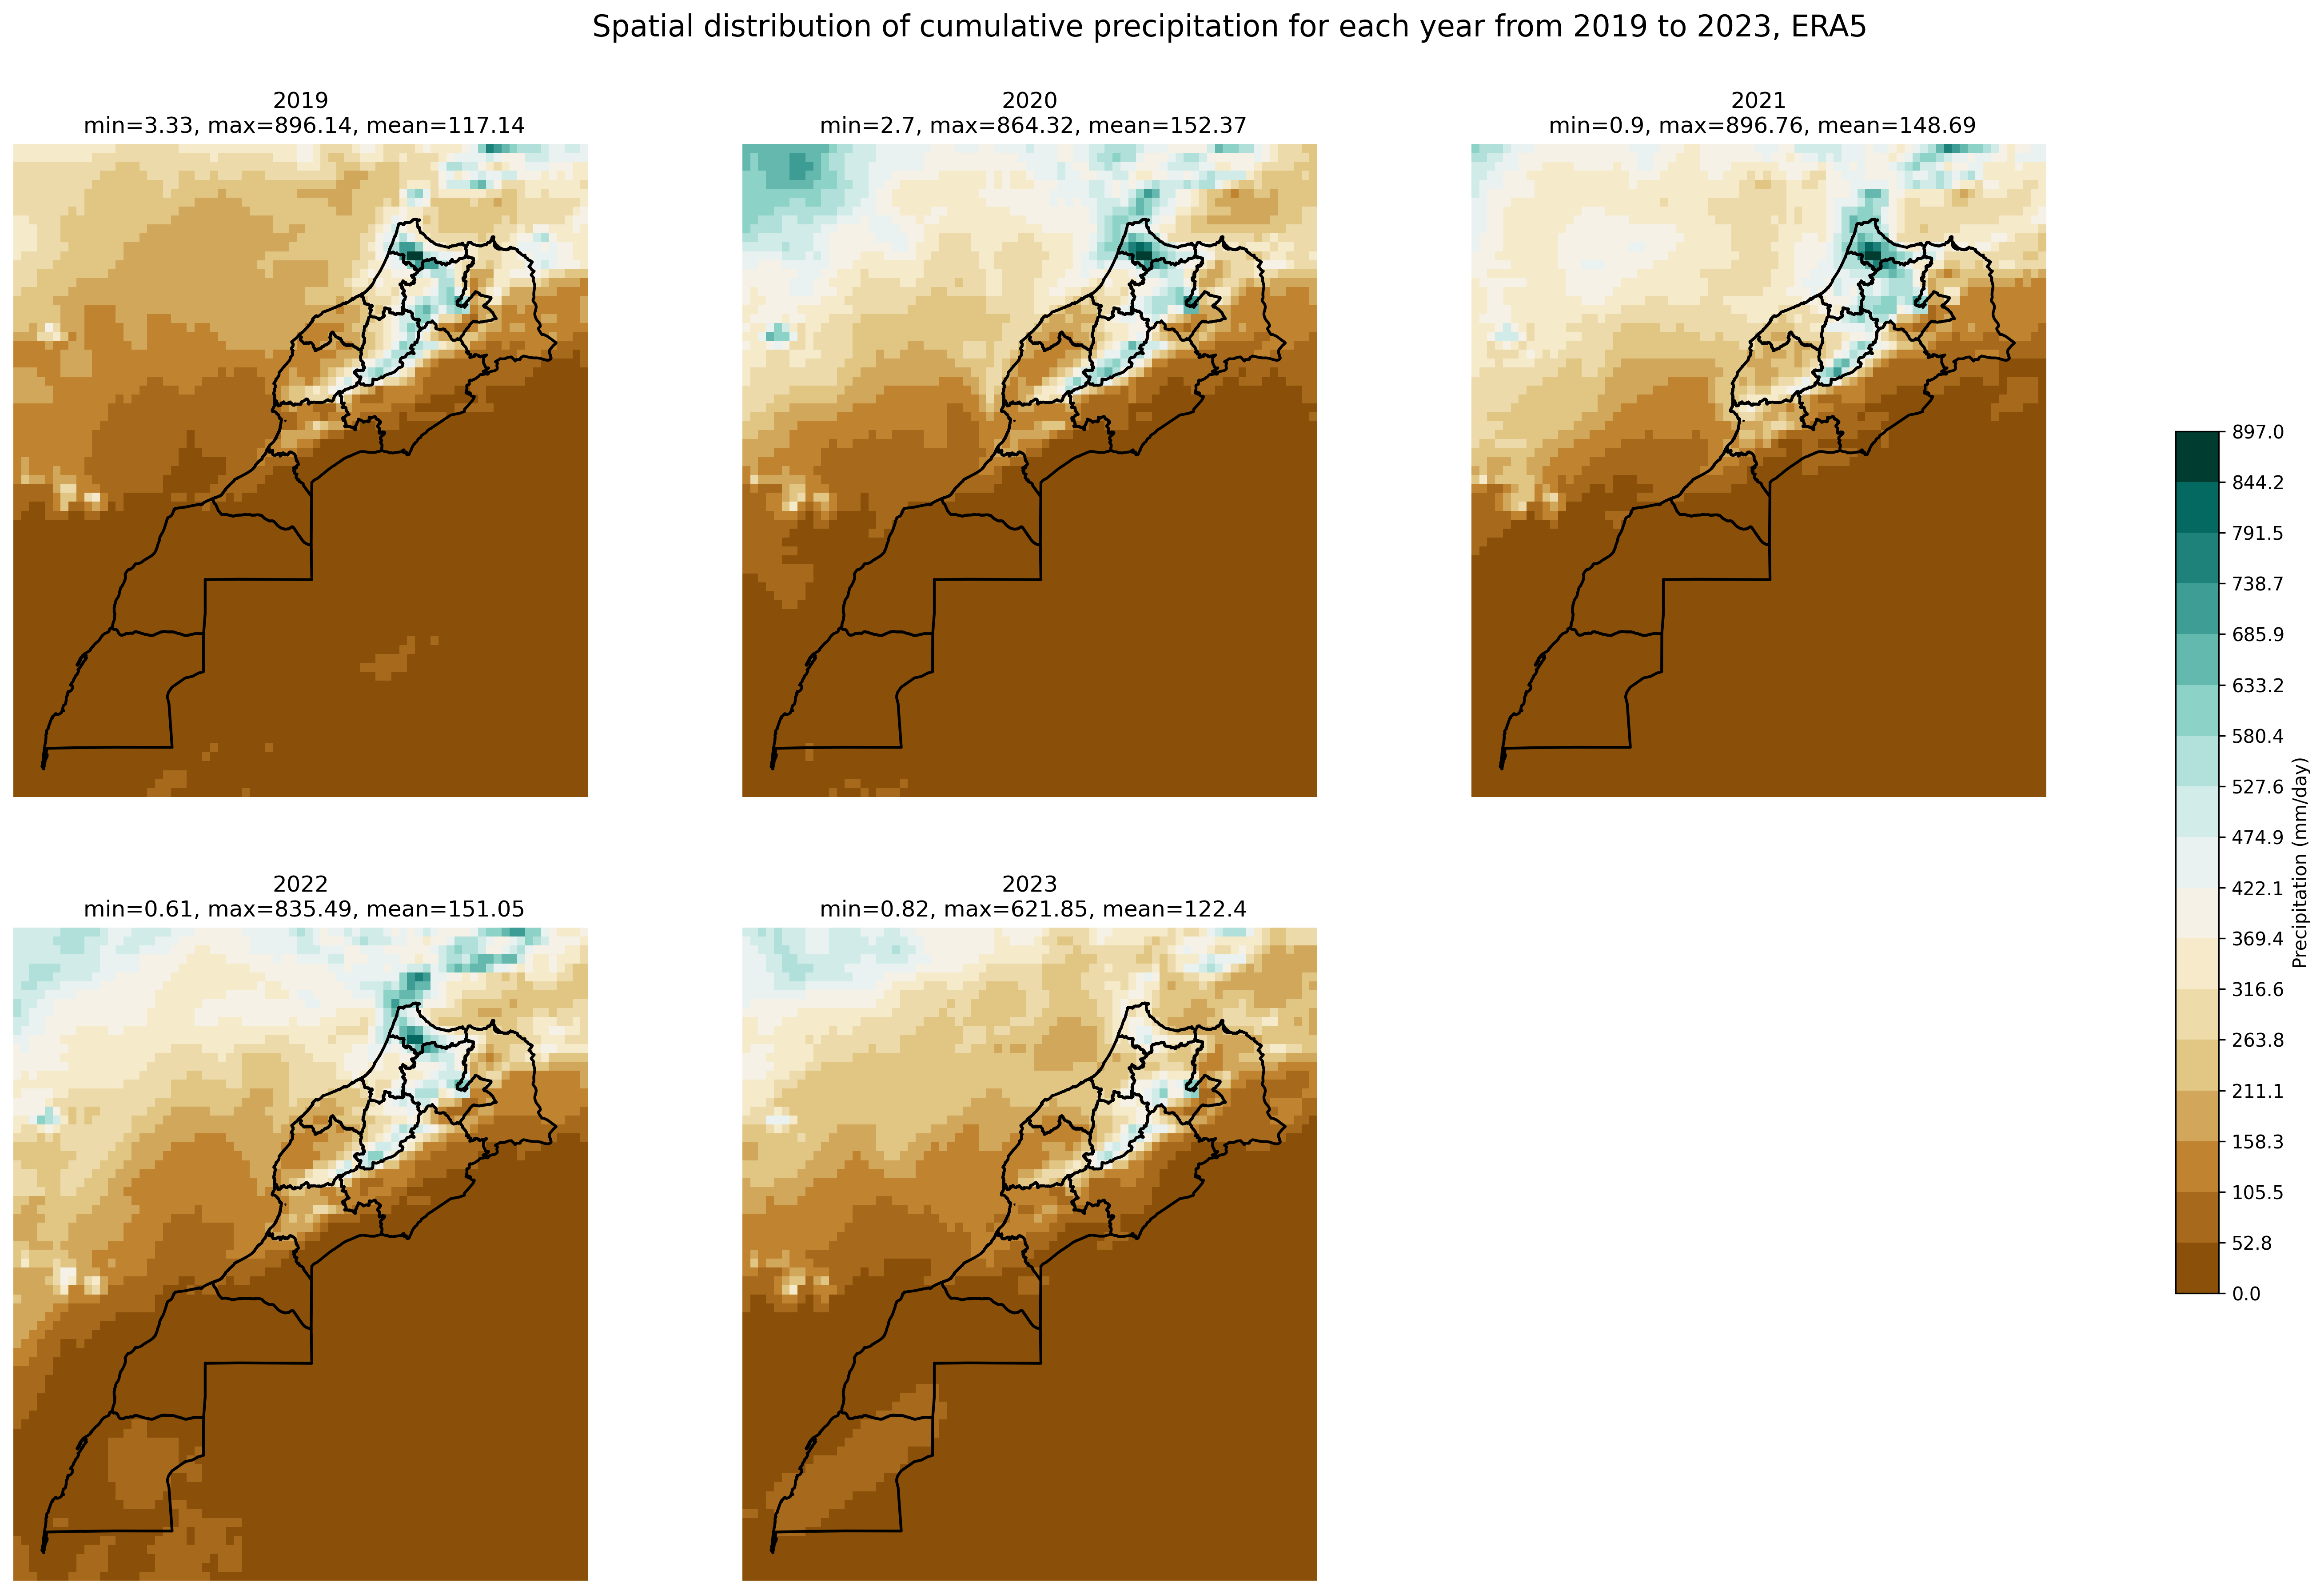

In [7]:
# The number of classes
max_val = np.ceil(max([np.max(v) for v in mean_precipitation.values()]))#900
num_classes = int(max_val / 50) + 1

# Longitude and latitude values
lon = ds_ERA5['longitude']
lat = ds_ERA5['latitude']

# Create a discrete colormap with brown to green colors
colors = mpl.cm.BrBG(np.linspace(0.1, 1, num_classes))
cmap = mpl.colors.ListedColormap(colors)

# Create a BoundaryNorm with the same number of boundaries as the colormap levels
bounds = np.linspace(0, max_val, num_classes)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=num_classes)

# Create subplots for each year
fig, axs = plt.subplots(2, 3, figsize=(25, 14), subplot_kw=dict(projection=ccrs.PlateCarree()), dpi=300)
# Plot the mean precipitation for each year
for i, year in enumerate(years):
    row = i // 3
    col = i % 3
    dataset = mean_precipitation[year]
    img = axs[row, col].imshow(dataset, extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap=cmap, norm=norm)
    morocco_boundary.boundary.plot(ax=axs[row, col], edgecolor='black')

    # Get statistics of the dataset
    max_val = np.round(float(dataset.max()), 2)
    min_val = np.round(float(dataset.min()), 2)
    mean_val = np.round(float(dataset.mean()), 2)

    axs[row, col].set_title(f'{year}\n min={min_val}, max={max_val}, mean={mean_val}', fontsize=12)
    axs[row, col].set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    axs[row, col].axis('off')

axs[1, 2].axis('off')

fig.suptitle('Spatial distribution of cumulative precipitation for each year from 2019 to 2023, ERA5', fontsize=16, x=0.5, y=0.95)

# Add a colorbar
cbar = plt.colorbar(img, ax=axs, label='Precipitation (mm/day)', pad=0.05, shrink=0.6)
cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, num_classes))

# Show the plot
plt.show()

- ### <span style="color:darkred;">Temporal distribution of monthly cumulative precipitation</span>

To examine the monthly precipitation, we will first exclude sea data from our analysis due to its limited relevance to land-based activities, such as agriculture and water resource management, which are central to climate studies. This strategic exclusion ensures a more focused examination of precipitation patterns in areas that directly impact these activities. Additionally, this approach accounts for the potential lower accuracy and uncertainties associated with precipitation measurements over the sea.

For this purpose, we will use the defined_regions.natural_earth_v5_0_0.land_110 tool, which obtains the landmask outline from Natural Earth.

In [8]:
# Create a region object
region_object = regionmask.defined_regions.natural_earth_v5_0_0.land_110

# Generate the mask
mask_ERA5 = region_object.mask(ds_ERA5['longitude'], ds_ERA5['latitude'])

# Apply the mask to the dataset
ds_ERA5_m = ds_ERA5.where(~np.isnan(mask_ERA5), drop=False)

In [9]:
# Extract unique years
years = ds_ERA5_m['time'].dt.year.values
unique_years = np.unique(years)

# Initialize a dictionary to hold the precipitation data for each year
monthly_precipitation = {}

for year in unique_years:
    # Filter data for the current year
    ds_year = ds_ERA5_m.sel(time=str(year))

    # Calculate monthly cumulative precipitation
    monthly_data = ds_year.groupby('time.month').sum(dim='time')
    monthly_precipitation[year] = monthly_data


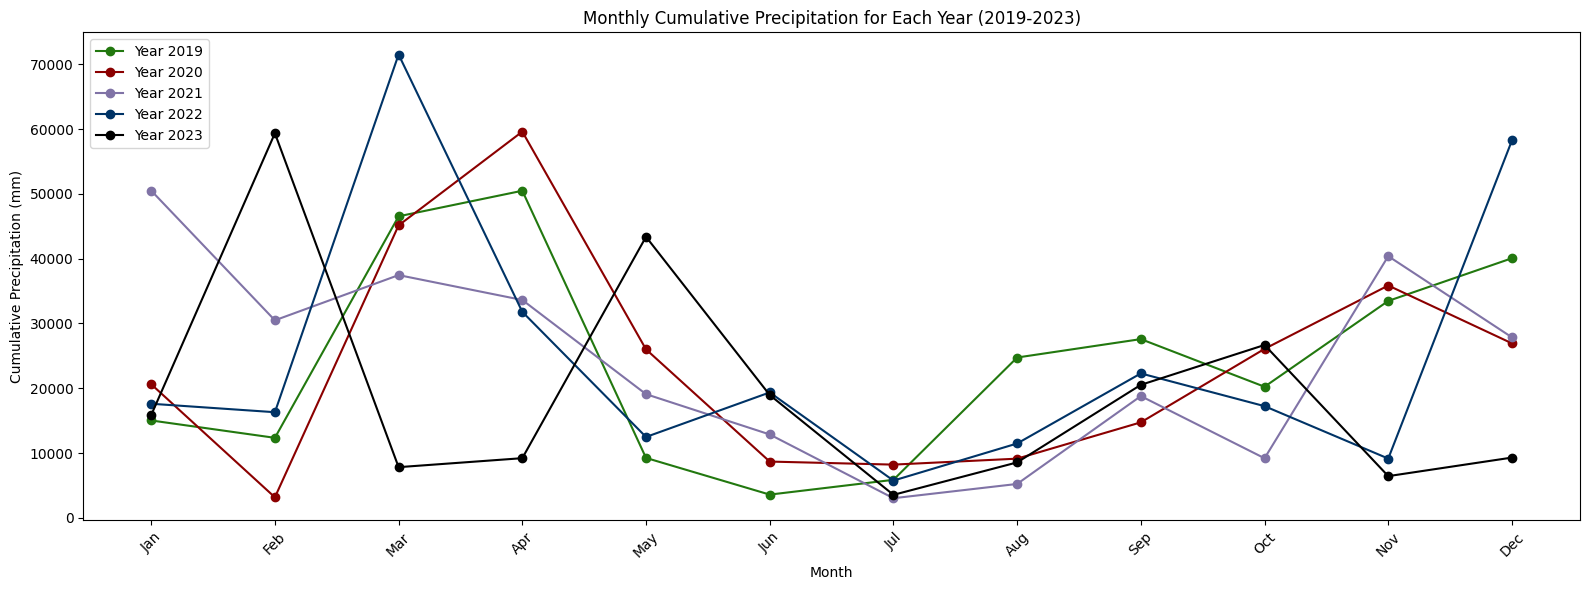

In [12]:
# Define specific colors for each year
colors = ['#22780F', 'darkred', (0.5, 0.45, 0.65), '#003366', 'black']

months = [calendar.month_abbr[i] for i in range(1, 13)]  # Get abbreviated month names

fig, ax = plt.subplots(figsize=(16, 6))

# Plot each year's monthly precipitation
for i, (year, data) in enumerate(monthly_precipitation.items()):
    monthly_sum = data['tp'].sum(dim=['longitude', 'latitude'])  # Sum over spatial dimensions
    ax.plot(data['month'], monthly_sum, label=f'Year {year}', color=colors[i], marker='o')

# Set x-axis to show month names
ax.set_xticks(range(1, 13))  # Set x-ticks to match the number of months
ax.set_xticklabels(months)   # Set x-tick labels to month names

# Set plot labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Cumulative Precipitation (mm)')
ax.set_title('Monthly Cumulative Precipitation for Each Year (2019-2023)')
ax.legend()

# Rotate and format the x-tick labels
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
